In [156]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

## Welcome!
In this notebook you can first find an example of an AutoEncoder on MNIST, and then the same things but done with a very simple VAE. I recommend to first try running the AE part setting the latent dimension equal to 2, in order to observe that the projection is, indeed, non-Gaussian. Then, by setting it to a higher value (10 is enough) you can see some good performance.

In [157]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:0


In [158]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # output: [16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # output: [32, 7, 7]
            nn.ReLU(),
            nn.Flatten(),  # output: [32*7*7]
            nn.Linear(32*7*7, latent_dim),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),  # Unflatten to [batch, 32, 7, 7]
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # output: [16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # output: [1, 28, 28]
            nn.Tanh(),  # Ensure output is in the range [-1, 1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

In [159]:
#function to show mnist images, after they are imported with the following normalization
def imshow_mnist(img):
    mean = 0.5
    std = 0.5
    img = img.numpy() 
    img = std * img + mean  
    img = np.clip(img, 0, 1)  
    plt.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

In [161]:
#this transform is used to normalize the images such that they have values between -1 and 1
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5), (0.5,))])

#load the mnist dataset, keep only the first 10000 images and create a dataloader
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = torch.utils.data.Subset(train_dataset, range(10000))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(train_dataset, batch_size=10000, shuffle=True)

#load the test dataset, keep only the first 10000 images and create a dataloader
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=True)

In [166]:
# Initialize the network and the optimizer
latent_dim = 10
AE_mnist = ConvAutoencoder(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(AE_mnist.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='mean')

In [167]:
# Train the Autoencoder
n_epochs = 10
for epoch in range(n_epochs):
    for data in train_loader:
        img, _ = data
        img=img.to(device)
        # Forward pass
        output, _ = AE_mnist(img)
        loss = criterion(output, img)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate training loss over the entire training set
    train_loss = 0
    with torch.no_grad():  # No need to track gradients
        for img,_ in train_loader_2:
            img=img.to(device)
            train_output,_ = AE_mnist(img)
            train_loss += criterion(train_output, img).item()     

    # Same for test
    test_loss = 0
    with torch.no_grad():
        for img,_ in test_loader:
            img=img.to(device)  
            test_output,_ = AE_mnist(img)
            test_loss += criterion(test_output, img).item()
    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}')

Epoch 1/10 - Train Loss: 0.19800913333892822, Test Loss: 0.1987243890762329
Epoch 2/10 - Train Loss: 0.12734518945217133, Test Loss: 0.1278834044933319
Epoch 3/10 - Train Loss: 0.1109415590763092, Test Loss: 0.11218950897455215
Epoch 4/10 - Train Loss: 0.1025129184126854, Test Loss: 0.10434361547231674
Epoch 5/10 - Train Loss: 0.09556633979082108, Test Loss: 0.09750372171401978
Epoch 6/10 - Train Loss: 0.09140705317258835, Test Loss: 0.093636155128479
Epoch 7/10 - Train Loss: 0.08715906739234924, Test Loss: 0.08972795307636261
Epoch 8/10 - Train Loss: 0.08438919484615326, Test Loss: 0.08722618222236633
Epoch 9/10 - Train Loss: 0.0818605124950409, Test Loss: 0.08500552922487259
Epoch 10/10 - Train Loss: 0.08022606372833252, Test Loss: 0.08350178599357605


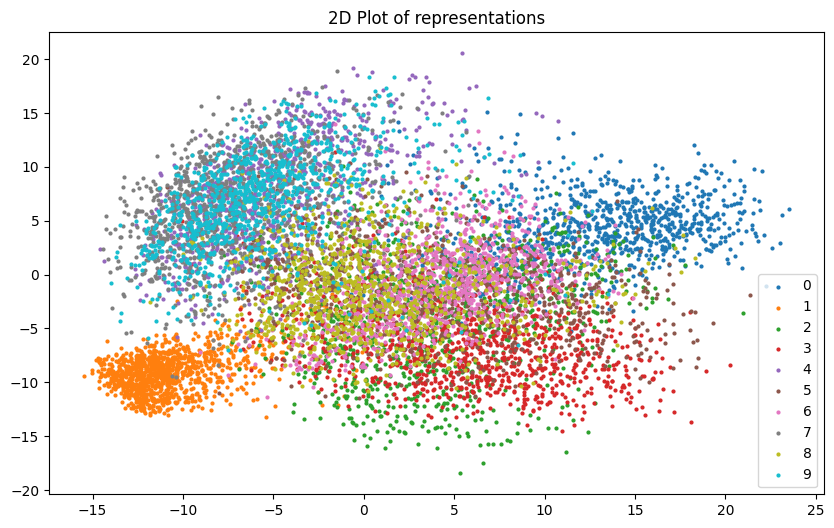

In [168]:
#after training, put back the network in the cpu
AE_mnist.to('cpu')

with torch.no_grad():
    # Get a batch of data and put it through the network
    images, labels = next(iter(test_loader))
    #images = images.view(images.size(0), -1)
    _, representations = AE_mnist(images)

if latent_dim!=2:
    pca = PCA(n_components=2)
    representations = pca.fit_transform(representations)
plt.figure(figsize=(10, 6))
for i in range(10):
    indices = labels == i
    plt.scatter(representations[indices, 0], representations[indices, 1], label=str(i), alpha=1, s=4)
plt.legend()
plt.title('2D Plot of representations')
plt.show()

Original Images


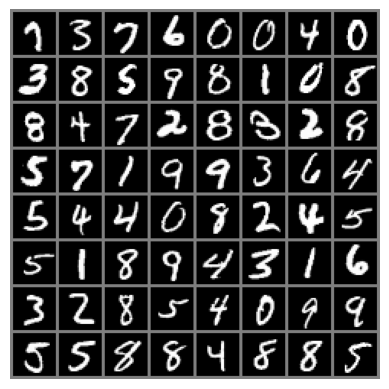

Reconstructed Images


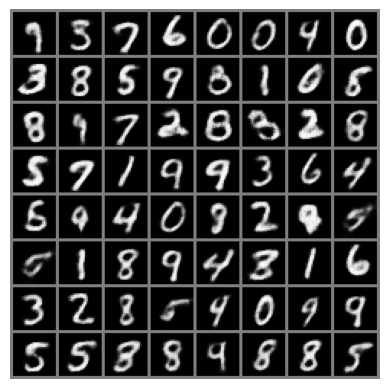

In [169]:
# Get a batch of test images
images, _ = next(iter(test_loader))
images = images[:64]
original_images = images 

# Pass the images through the network and get the reconstructed images
reconstructed, _ = AE_mnist(images)

# Display original images
print("Original Images")
imshow_mnist(torchvision.utils.make_grid(original_images))
plt.show()

# Display reconstructed images
print("Reconstructed Images")
imshow_mnist(torchvision.utils.make_grid(reconstructed))
plt.show()

## VAEs time!
The data have already been loaded before. We will basically use the same architecture. You need to do the following steps:
1) Project every sample to a latent distribution (a Gaussian) instead of a single point in the latent space
2) Define the reparameterization trick and the forward pass of the model
3) Implement a function that evaluates the KL divergence between a Gaussian and a standard Gaussian (mean 0, std 1). You can assume that the covariance matrix in the latent space is diagonal

Notice that the parameters that you find below work when the reduction of the loss function is set to 'sum', so try to define an "extensive" KL divergence (aka scales linearly in the batch size and dimensions), otherwise you are free to find some other parameters that work well for you

In [144]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten() # output: [32*7*7]
        )

        ####### Add the layers that gets you the Gaussian parameters here  #######
        ####### Recommended parameterization: mu and logvar #######
        self.fc_mu = nn.Linear(32*7*7, latent_dim)
        self.fc_logvar = nn.Linear(32*7*7, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )
    #write the reparameterization trick here
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    #define the forward pass, that returns a reconstructed image and the parameters of the atent distribution 
    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar
    
#define the Kullback-Leibler divergence between the Gaussian distribution of the latent space and a standard Gaussian
def KL_divergence(mu, logvar, reduction = 'mean'):
    if reduction == 'mean':
        return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    else:
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


In [179]:
# Initialize the network and the optimizer
latent_dim = 2
VAE_mnist = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(VAE_mnist.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='sum')

In [180]:
# Train the Autoencoder
n_epochs = 10
for epoch in range(n_epochs):
    for data in train_loader:
        img, _ = data
        img=img.to(device)
        # Here do a forward pass and evaluate the loss
        output, mu, logvar = VAE_mnist(img)
        loss = criterion(output, img)+KL_divergence(mu, logvar, reduction='sum')
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate training loss over the entire training set
    train_loss = 0
    with torch.no_grad():  # No need to track gradients
        for img,_ in train_loader_2:
            img=img.to(device)
            train_output, mu, logvar = VAE_mnist(img)
            train_loss += criterion(train_output, img).item()     
    train_loss /= (len(train_loader_2))

    # Same for test
    test_loss = 0
    with torch.no_grad():
        for img,_ in test_loader:
            img=img.to(device)  
            test_output, mu, logvar = VAE_mnist(img)
            test_loss += criterion(test_output, img).item()
    test_loss /= (len(test_loader))
    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}')


Epoch 1/10 - Train Loss: 1962399.0, Test Loss: 1972084.625
Epoch 2/10 - Train Loss: 1742289.375, Test Loss: 1749658.0
Epoch 3/10 - Train Loss: 1675906.5, Test Loss: 1684655.25
Epoch 4/10 - Train Loss: 1634629.125, Test Loss: 1645621.375
Epoch 5/10 - Train Loss: 1600550.5, Test Loss: 1614784.5
Epoch 6/10 - Train Loss: 1568623.75, Test Loss: 1585560.25
Epoch 7/10 - Train Loss: 1542159.25, Test Loss: 1560347.25
Epoch 8/10 - Train Loss: 1531368.0, Test Loss: 1551262.5
Epoch 9/10 - Train Loss: 1511911.625, Test Loss: 1531277.875
Epoch 10/10 - Train Loss: 1505307.75, Test Loss: 1528970.25


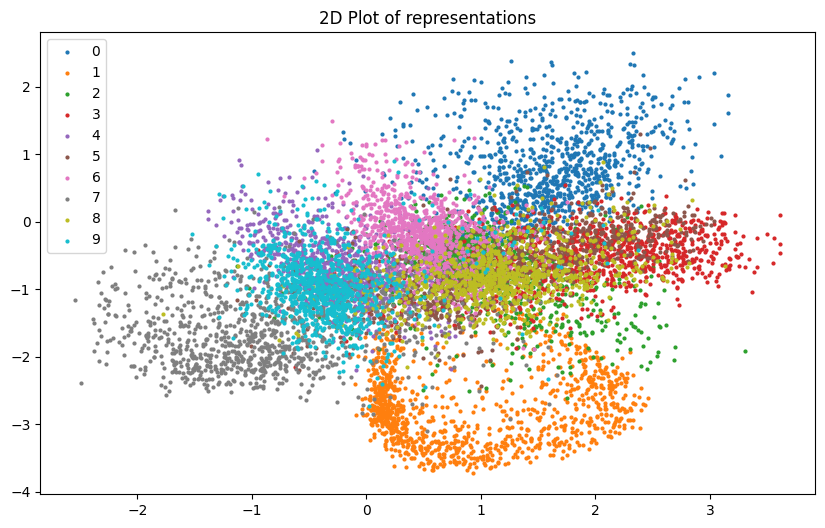

In [181]:
#after training, put back the network in the cpu
VAE_mnist.to('cpu')

with torch.no_grad():
    # Get a batch of data and put it through the network
    images, labels = next(iter(test_loader))
    #images = images.view(images.size(0), -1)
    _, representations, _ = VAE_mnist(images)

if latent_dim!=2:
    pca = PCA(n_components=2)
    representations = pca.fit_transform(representations)
plt.figure(figsize=(10, 6))
for i in range(10):
    indices = labels == i
    plt.scatter(representations[indices, 0], representations[indices, 1], label=str(i), alpha=1, s=4)
plt.legend()
plt.title('2D Plot of representations')
plt.show()

Original Images


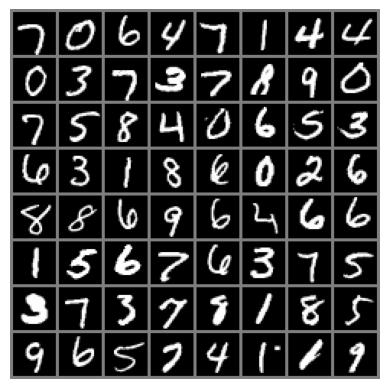

Reconstructed Images


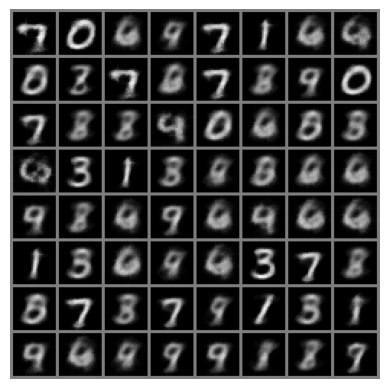

In [182]:
#after training, put back the network in the cpu
VAE_mnist.to('cpu')

# Get a batch of test images
images, _ = next(iter(test_loader))
images = images[:64]
original_images = images  # Save the original images for comparison

# Pass the images through the network and get the reconstructed images
reconstructed, _, _ = VAE_mnist(images)

# Display original images
print("Original Images")
imshow_mnist(torchvision.utils.make_grid(original_images))
plt.show()

# Display reconstructed images
print("Reconstructed Images")
imshow_mnist(torchvision.utils.make_grid(reconstructed))
plt.show()

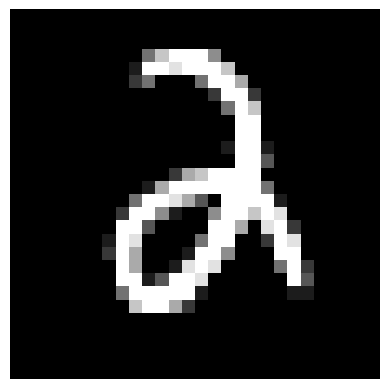

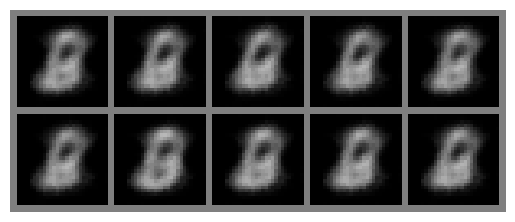

In [183]:
with torch.no_grad():
    # Get a batch of data and put it through the network
    images, labels = next(iter(test_loader))
    images = images[:1]  # Select the first image of the batch
    imshow_mnist(torchvision.utils.make_grid(images))
    original_images = images  # Save the original images for comparison
    
    # Initialize a list to hold the reconstructions
    reconstructions = []
    
    # Generate multiple reconstructions
    for i in range(10):
        reconstructed, _, _ = VAE_mnist(images)
        reconstructions.append(reconstructed.squeeze(0))  # Remove batch dim if exists

    # Convert list of tensors to a single tensor
    reconstructions = torch.stack(reconstructions)

# Visualize the reconstructions
imshow_mnist(torchvision.utils.make_grid(reconstructions, nrow=5))  # Adjust 'nrow' as needed
plt.show()

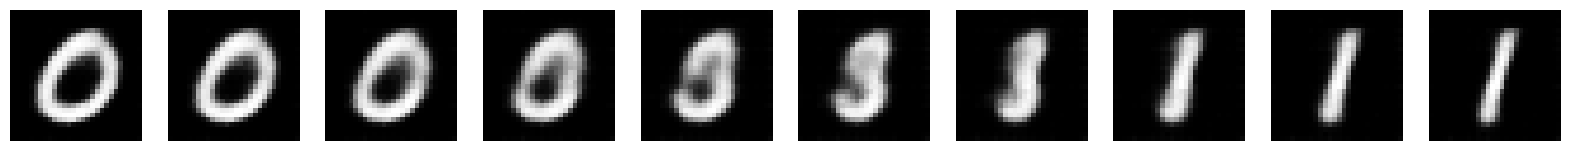

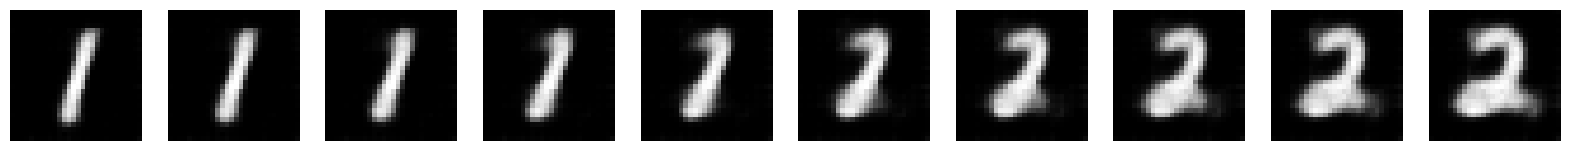

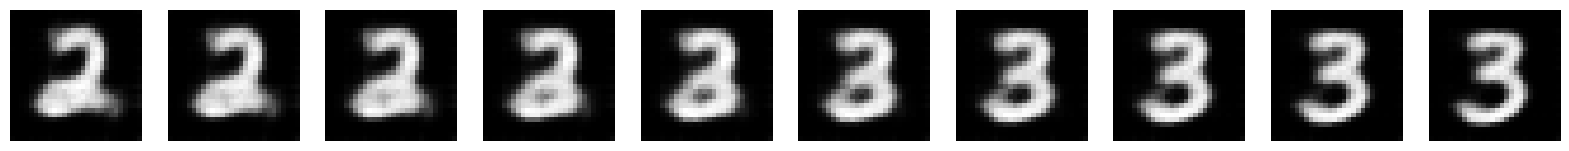

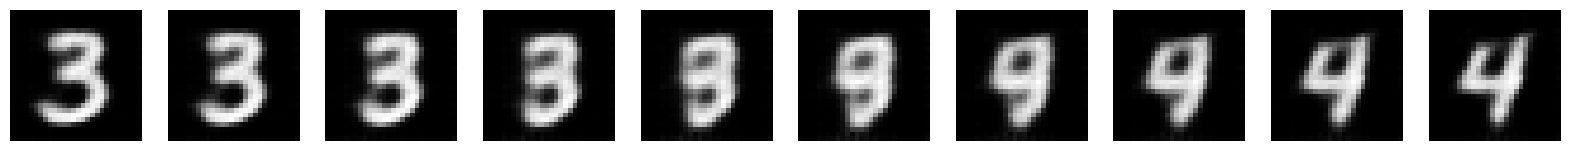

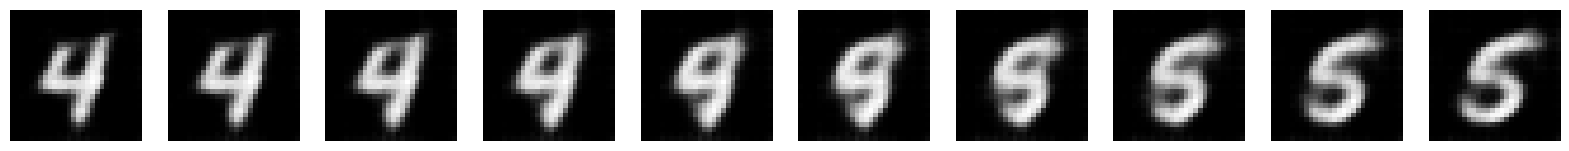

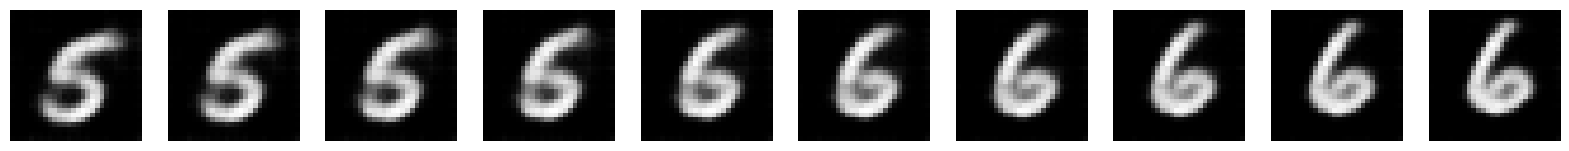

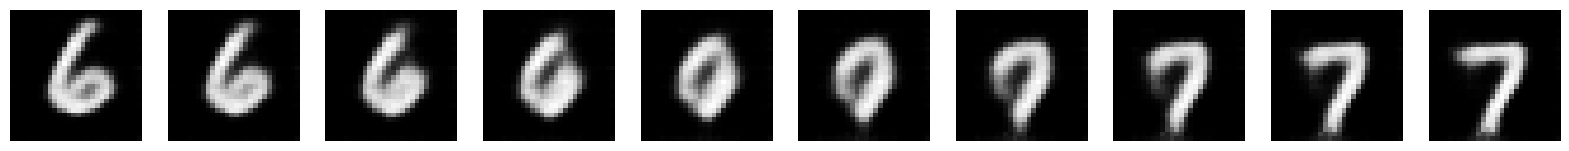

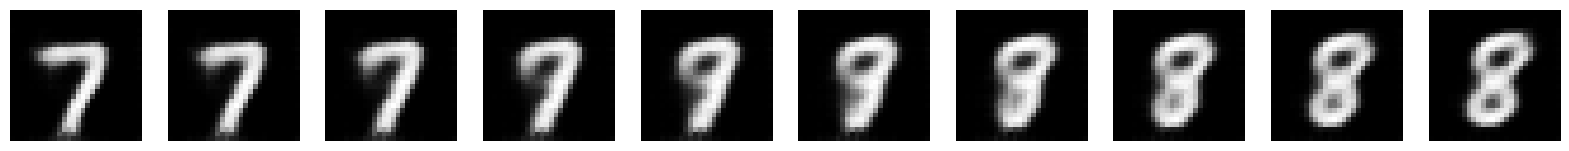

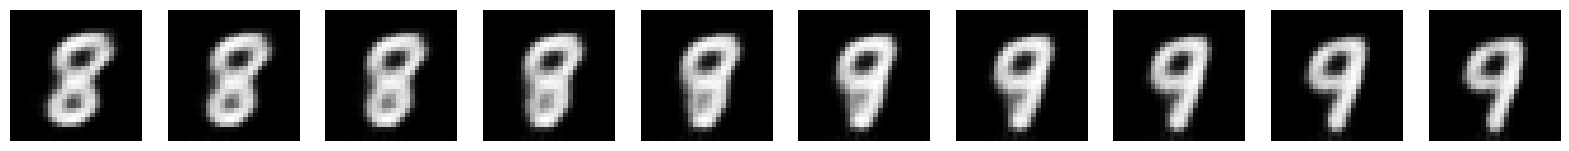

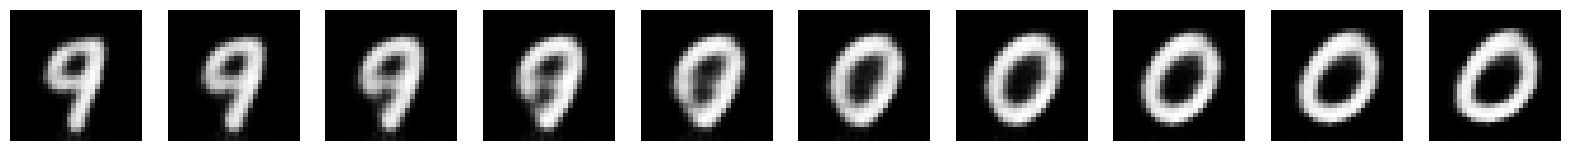

In [170]:
def interpolate_points(p1, p2, n_steps=10):
    # Linear interpolation between two points in latent space
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = [(1 - alpha) * p1 + alpha * p2 for alpha in ratios]
    return np.array(vectors)

def generate_images_from_path(vae, start_point, end_point, n_steps=10):
    # Ensure the model is in evaluation mode
    vae.eval()
    
    # Interpolate between the start and end points
    z_points = interpolate_points(start_point, end_point, n_steps=n_steps)
    
    # Generate images along the path
    images = []
    with torch.no_grad():
        for z in z_points:
            z_tensor = torch.from_numpy(z).float().unsqueeze(0) # Add batch dimension
            img = vae.decoder(z_tensor)
            images.append(img.cpu().squeeze().numpy())  # Remove batch dimension and transfer to CPU
    
    # Plotting
    fig, axes = plt.subplots(1, n_steps, figsize=(n_steps * 2, 2))
    for i, img in enumerate(images):
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    plt.show()

def get_mean_latent_vector(vae, data_loader, digit):
    mu_total = []
    with torch.no_grad():
        for images, labels in data_loader:
            # Filter images by digit
            filtered_indices = labels == digit
            filtered_images = images[filtered_indices]
            if len(filtered_images) > 0:
                encoded = vae.encoder(filtered_images)
                mu = vae.fc_mu(encoded)
                mu_total.append(mu.cpu())
    mu_mean = torch.cat(mu_total, dim=0).mean(dim=0)  # Average mu across all selected images
    return mu_mean


starting_digit = 1
ending_digit = 6

for i in range(10):
    starting_digit = i
    ending_digit = (i+1)%10
    mu_start = get_mean_latent_vector(VAE_mnist, train_loader_2, digit=starting_digit).numpy()
    mu_end = get_mean_latent_vector(VAE_mnist, train_loader_2, digit=ending_digit).numpy()

    generate_images_from_path(VAE_mnist, mu_start, mu_end, n_steps=10)